In [1]:
import os
os.chdir("/Users/Mohammed/Desktop/SMALLMOL_MD")

bbb_martins — N=122 | RDKit=129 | MD-only=20 | RDKit+MD=151
Train: 97 (pos=52, neg=45) | Test: 25 (pos=14, neg=11)
▶ RDKit only: F1=0.300 | Acc=0.440 | ROC-AUC=0.506 | best_params={'subsample': 0.8, 'n_estimators': 400, 'max_depth': 5, 'learning_rate': 0.005, 'colsample_bytree': 1.0}
▶ RDKit + MD: F1=0.786 | Acc=0.760 | ROC-AUC=0.802 | best_params={'subsample': 1.0, 'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.005, 'colsample_bytree': 1.0}


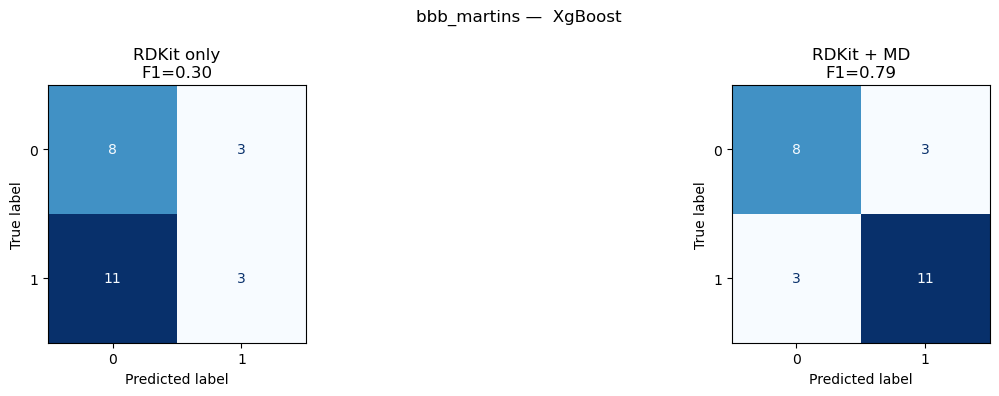

▶ RDKit + MD (SHAP-selected): F1=0.741 | Acc=0.720 | ROC-AUC=0.812 | best_params={'subsample': 1.0, 'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.005, 'colsample_bytree': 1.0}

Saved: bbb_martins_holdout20_rs42_summary.json, bbb_martins_holdout20_rs42_test_probas.csv, bbb_martins_holdout20_rs42_rdkit_md_shap_importance.csv


In [231]:
# === 20% stratified hold-out with nested CV and SHAP feature selection ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap

from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit, RandomizedSearchCV
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

# ---------------------------
# Config
# ---------------------------
DATA_FILE = "MD_ADMET_RDKIT_FS.csv"
DATASET_NAME = "bbb_martins"
RANDOM_STATE = 42
TEST_SIZE = 0.2

param_grid = {
    "n_estimators": [100, 200, 300, 400, 500, 600, 800],
    "max_depth": [3, 4, 5, 6, 7],
    "learning_rate": [0.005, 0.01, 0.02, 0.05, 0.1],
    "subsample": [0.7, 0.8, 0.9, 1.0],
    "colsample_bytree": [0.7, 0.8, 0.9, 1.0],
}

meta_cols = ["ID", "smiles", "dataset", "Y"]

md_cols = [
    "mean_length", "std_length", "min_length", "max_length",
    "mean_rg", "std_rg",
    "mean_area", "std_area",
    "mean_tpsa", "std_tpsa",
    "convergence_score",
    "folding_index_rg", "folding_index_l",
    "flexibility_index",
    "mean_com_disp", "max_com_disp", "p95_com_disp",
    "mean_rmsd", "max_rmsd",
    "diff_coeff", "hbonds_mean", "hbonds_std"
]

# ---------------------------
# Load + slice dataset
# ---------------------------
df = pd.read_csv(DATA_FILE)
df_d = df[df["dataset"] == DATASET_NAME].copy()
df_d = df_d[df_d["Y"].isin([0, 1])].dropna(subset=["Y"])
y_all = df_d["Y"].astype(int)

missing = [c for c in md_cols if c not in df_d.columns]
if missing:
    raise ValueError(f"Missing MD columns in data: {missing}")

X_rdkit_all   = df_d.drop(columns=meta_cols + md_cols, errors="ignore").select_dtypes(include=[np.number])
X_md_all      = df_d.drop(columns=meta_cols, errors="ignore").select_dtypes(include=[np.number])

print(f"{DATASET_NAME} — N={len(df_d)} | RDKit={X_rdkit_all.shape[1]} | MD-only={X_md_only_all.shape[1]} | RDKit+MD={X_md_all.shape[1]}")

# ---------------------------
# Train/test split
# ---------------------------
sss = StratifiedShuffleSplit(n_splits=1, test_size=TEST_SIZE, random_state=RANDOM_STATE)
(tr_idx, te_idx), = sss.split(X_rdkit_all, y_all)

def split_by_index(X):
    return X.iloc[tr_idx].reset_index(drop=True), X.iloc[te_idx].reset_index(drop=True)

Xr_tr, Xr_te = split_by_index(X_rdkit_all)
Xm_tr, Xm_te = split_by_index(X_md_all)
y_tr, y_te = y_all.iloc[tr_idx].reset_index(drop=True), y_all.iloc[te_idx].reset_index(drop=True)

print(f"Train: {len(y_tr)} (pos={int((y_tr==1).sum())}, neg={int((y_tr==0).sum())}) | "
      f"Test: {len(y_te)} (pos={int((y_te==1).sum())}, neg={int((y_te==0).sum())})")

# ---------------------------
# Training + Evaluation
# ---------------------------
def tune_fit_eval(X_tr, y_tr, X_te, y_te, label):
    pos = max(int((y_tr == 1).sum()), 1)
    neg = int((y_tr == 0).sum())
    spw = neg / pos

    base = XGBClassifier(
        eval_metric="logloss",
        random_state=RANDOM_STATE,
        n_jobs=-1,
        scale_pos_weight=spw,
        tree_method="hist",
    )
    inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    search = RandomizedSearchCV(
        base,
        param_distributions=param_grid,
        n_iter=15,
        scoring="f1",
        cv=inner_cv,
        n_jobs=-1,
        refit=True,
        verbose=0,
        random_state=RANDOM_STATE
    )
    search.fit(X_tr, y_tr)
    best = search.best_estimator_

    best.fit(X_tr, y_tr)
    proba = best.predict_proba(X_te)[:, 1]
    y_pred = (proba >= 0.5).astype(int)

    f1  = f1_score(y_te, y_pred)
    acc = accuracy_score(y_te, y_pred)
    try:
        auc = roc_auc_score(y_te, proba)
    except ValueError:
        auc = np.nan

    print(f"▶ {label}: F1={f1:.3f} | Acc={acc:.3f} | ROC-AUC={auc:.3f} | best_params={search.best_params_}")
    return best, y_pred, proba, f1, acc, auc, search.best_params_

# Train all three
best_r,  yhat_r,  proba_r,  f1_r,  acc_r,  auc_r,  p_r   = tune_fit_eval(Xr_tr, y_tr, Xr_te, y_te, "RDKit only")
best_m,  yhat_m,  proba_m,  f1_m,  acc_m,  auc_m,  p_m   = tune_fit_eval(Xm_tr, y_tr, Xm_te, y_te, "RDKit + MD")

# ---------------------------
# Confusion matrices
# ---------------------------
fig, axs = plt.subplots(1, 2, figsize=(16, 4))
for ax, preds, title in [
    (axs[0], yhat_r,  f"RDKit only\nF1={f1_r:.2f}"),
    (axs[1], yhat_m,  f"RDKit + MD\nF1={f1_m:.2f}"),
]:
    cm = confusion_matrix(y_te, preds, labels=[0,1])
    disp = ConfusionMatrixDisplay(cm, display_labels=[0,1])
    disp.plot(ax=ax, values_format="d", cmap="Blues", colorbar=False)
    ax.set_title(title)
plt.suptitle(f"{DATASET_NAME} —  XgBoost")
plt.tight_layout()
plt.show()

# ---------------------------
# SHAP Feature Selection on RDKit + MD
# ---------------------------
explainer = shap.Explainer(best_m, Xm_tr, feature_names=Xm_tr.columns)
shap_values = explainer(Xm_tr)

# Example: Beeswarm SHAP summary with custom title + save
shap.summary_plot(
    shap_values, Xm_tr,
    max_display=10, plot_type="dot", show=False
)

# Adjust figure size (width ↓, height same or slightly taller)
plt.gcf().set_size_inches(5, 5)  # width=6 inches, height=5 inches

# Add custom title
plt.title("BBB", fontsize=14, pad=20, fontweight="bold")

for label in plt.gca().get_yticklabels():
    label.set_fontweight("bold")


# Layout & save
plt.tight_layout()
plt.savefig("bbb_shap_top10.png", dpi=300)
plt.close()

# Rank features
mean_abs_shap = np.abs(shap_values.values).mean(axis=0)
shap_df = pd.DataFrame({"feature": Xm_tr.columns, "mean_abs_shap": mean_abs_shap})
shap_df = shap_df.sort_values("mean_abs_shap", ascending=False)
top_k = 20
top_features = shap_df["feature"].head(top_k).tolist()

# Retrain using top SHAP-selected features
Xm_tr_top = Xm_tr[top_features]
Xm_te_top = Xm_te[top_features]
best_m_shap, yhat_m_shap, proba_m_shap, f1_m_shap, acc_m_shap, auc_m_shap, p_m_shap = \
    tune_fit_eval(Xm_tr_top, y_tr, Xm_te_top, y_te, "RDKit + MD (SHAP-selected)")

# ---------------------------
# Save outputs
# ---------------------------
out_prefix = f"{DATASET_NAME}_holdout{int(TEST_SIZE*100)}_rs{RANDOM_STATE}"
pd.DataFrame({
    "set": ["RDKit", "RDKit+MD", "RDKit+MD (SHAP-selected)"],
    "F1":  [f1_r, f1_m, f1_m_shap],
    "Acc": [acc_r, acc_m, acc_m_shap],
    "AUC": [auc_r, auc_m, auc_m_shap],
    "best_params": [p_r, p_m, p_m_shap],
}).to_json(f"{out_prefix}_summary.json", orient="records", indent=2)

pd.DataFrame({"y_true": y_te, "proba_rdkit": proba_r, "proba_mdonly": proba_mo, "proba_rdkit_md": proba_m,
              "proba_rdkit_md_shap": proba_m_shap}).to_csv(f"{out_prefix}_test_probas.csv", index=False)

shap_df.to_csv(f"{out_prefix}_rdkit_md_shap_importance.csv", index=False)

print("\nSaved:",
      f"{out_prefix}_summary.json,",
      f"{out_prefix}_test_probas.csv,",
      f"{out_prefix}_rdkit_md_shap_importance.csv")

bbb_martins — N=122 | RDKit=129 | MD-only=20 | RDKit+MD=151
Train: 97 (pos=52, neg=45) | Test: 25 (pos=14, neg=11)
▶ RDKit only: F1=0.316 | Acc=0.480 | ROC-AUC=0.390 | best={'clf__n_estimators': 800, 'clf__min_samples_split': 10, 'clf__min_samples_leaf': 4, 'clf__max_features': None, 'clf__max_depth': 6, 'clf__bootstrap': True}
▶ RDKit + MD: F1=0.692 | Acc=0.680 | ROC-AUC=0.760 | best={'clf__n_estimators': 800, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 1, 'clf__max_features': None, 'clf__max_depth': 6, 'clf__bootstrap': True}


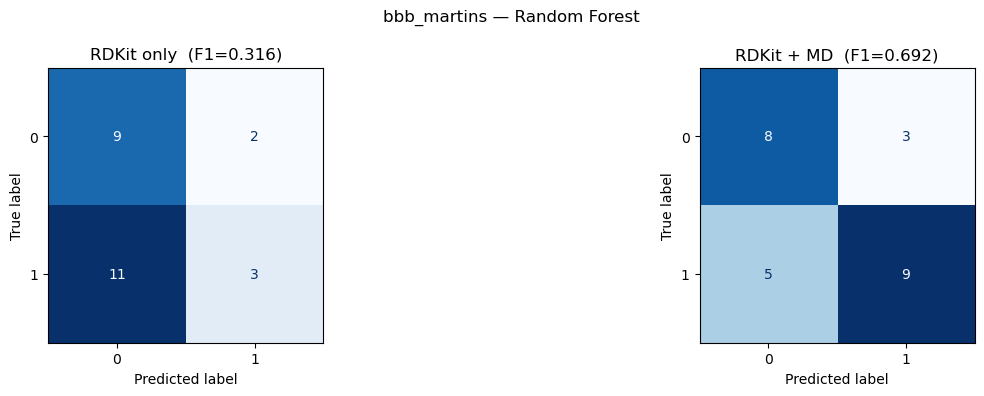

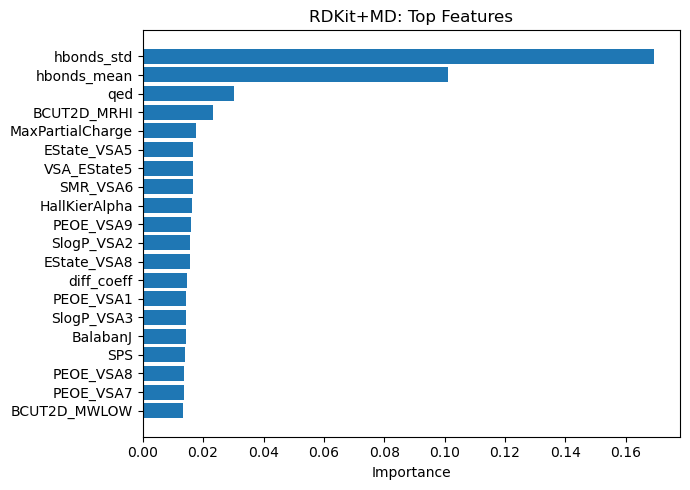


Saved metrics → bbb_martins_rf_holdout_summary.csv
Saved JSON → bbb_martins_rf_holdout_summary.json


In [205]:
# === Random Forest classification on RDKit / MD / RDKit+MD ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

# ---------------------------
# Config
# ---------------------------
DATA_FILE    = "MD_ADMET_RDKIT_FS.csv"   # change if needed
DATASET_NAME = "bbb_martins"
TEST_SIZE    = 0.2
RANDOM_STATE = 42

# explicit meta + MD columns
meta_cols = ["ID", "smiles", "dataset", "Y"]
md_cols = [
    "mean_length", "std_length", "min_length", "max_length",
    "mean_rg", "std_rg",
    "mean_area", "std_area",
    "mean_tpsa", "std_tpsa",
    "convergence_score",
    "folding_index_rg", "folding_index_l",
    "flexibility_index",
    "mean_com_disp", "max_com_disp", "p95_com_disp",
    "mean_rmsd", "max_rmsd",
    "diff_coeff", "hbonds_mean", "hbonds_std"
]

# RF hyperparameter space
rf_param_space = {
    "clf__n_estimators":      [100, 200, 300, 500, 600, 800],
    "clf__max_depth":         [None, 6, 8, 12],
    "clf__min_samples_split": [2, 5, 10],
    "clf__min_samples_leaf":  [1, 2, 4, 8],
    "clf__max_features":      ["sqrt", "log2", None],
    "clf__bootstrap":         [True, False],
}

# ---------------------------
# Load + slice
# ---------------------------
df = pd.read_csv(DATA_FILE)
df_d = df[df["dataset"] == DATASET_NAME].copy()
df_d = df_d[df_d["Y"].isin([0, 1])].dropna(subset=["Y"])
y_all = df_d["Y"].astype(int)

missing = [c for c in md_cols if c not in df_d.columns]
if missing:
    raise ValueError(f"Missing MD columns: {missing}")

# Build feature sets
X_rdkit_all   = df_d.drop(columns=meta_cols + md_cols, errors="ignore").select_dtypes(include=[np.number])
X_md_all      = df_d.drop(columns=meta_cols, errors="ignore").select_dtypes(include=[np.number])

print(f"{DATASET_NAME} — N={len(df_d)} | RDKit={X_rdkit_all.shape[1]} | MD-only={X_md_only_all.shape[1]} | RDKit+MD={X_md_all.shape[1]}")

# ---------------------------
# Train / test split (stratified)
# ---------------------------
sss = StratifiedShuffleSplit(n_splits=1, test_size=TEST_SIZE, random_state=RANDOM_STATE)
(tr_idx, te_idx), = sss.split(X_rdkit_all, y_all)

def split(X):
    return X.iloc[tr_idx].reset_index(drop=True), X.iloc[te_idx].reset_index(drop=True)

Xr_tr, Xr_te = split(X_rdkit_all)
Xm_tr, Xm_te = split(X_md_all)
y_tr = y_all.iloc[tr_idx].reset_index(drop=True)
y_te = y_all.iloc[te_idx].reset_index(drop=True)

print(f"Train: {len(y_tr)} (pos={int((y_tr==1).sum())}, neg={int((y_tr==0).sum())}) | "
      f"Test: {len(y_te)} (pos={int((y_te==1).sum())}, neg={int((y_te==0).sum())})")

# ---------------------------
# Helper: tune, fit, eval (Random Forest)
# ---------------------------
def tune_fit_eval_rf(X_tr, y_tr, X_te, y_te, label):
    # pipeline: impute NaNs → RF
    pipe = Pipeline([
        ("imputer", SimpleImputer(strategy="constant", fill_value=0)),
        ("clf", RandomForestClassifier(
            n_jobs=-1,
            random_state=RANDOM_STATE,
            class_weight="balanced"  # helps with imbalance
        ))
    ])

    inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    search = RandomizedSearchCV(
        pipe,
        param_distributions=rf_param_space,
        n_iter=25,
        scoring="f1",
        cv=inner_cv,
        n_jobs=-1,
        verbose=0,
        random_state=RANDOM_STATE,
        refit=True
    )
    search.fit(X_tr, y_tr)
    best = search.best_estimator_

    # predictions
    prob = best.predict_proba(X_te)[:, 1]
    y_pred = (prob >= 0.5).astype(int)

    f1  = f1_score(y_te, y_pred)
    acc = accuracy_score(y_te, y_pred)
    try:
        auc = roc_auc_score(y_te, prob)
    except ValueError:
        auc = np.nan

    print(f"▶ {label}: F1={f1:.3f} | Acc={acc:.3f} | ROC-AUC={auc:.3f} | best={search.best_params_}")
    return best, y_pred, prob, f1, acc, auc

# ---------------------------
# Train all three (in requested order)
# ---------------------------
best_r,  yhat_r,  proba_r,  f1_r,  acc_r,  auc_r  = tune_fit_eval_rf(Xr_tr,  y_tr, Xr_te,  y_te, "RDKit only")
best_m,  yhat_m,  proba_m,  f1_m,  acc_m,  auc_m  = tune_fit_eval_rf(Xm_tr,  y_tr, Xm_te,  y_te, "RDKit + MD")

# ---------------------------
# Confusion matrices
# ---------------------------
plt.figure(figsize=(15, 4))
for i, (preds, title) in enumerate([
    (yhat_r,  f"RDKit only  (F1={f1_r:.3f})"),
    (yhat_m,  f"RDKit + MD  (F1={f1_m:.3f})"),
]):
    ax = plt.subplot(1, 2, i+1)
    cm = confusion_matrix(y_te, preds, labels=[0, 1])
    ConfusionMatrixDisplay(cm, display_labels=[0, 1]).plot(ax=ax, values_format="d", cmap="Blues", colorbar=False)
    ax.set_title(title)
plt.suptitle(f"{DATASET_NAME} — Random Forest")
plt.tight_layout()
plt.show()

# ---------------------------
# Feature importances (top 20)
# ---------------------------
def plot_importances(model, X_cols, title, topn=20):
    # model is Pipeline; the RF is model.named_steps["clf"]
    rf = model.named_steps["clf"]
    importances = rf.feature_importances_
    idx = np.argsort(importances)[::-1][:topn]
    names = np.array(X_cols)[idx]
    vals = importances[idx]

    plt.figure(figsize=(7, 5))
    plt.barh(names[::-1], vals[::-1])
    plt.xlabel("Importance")
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_importances(best_m,  Xm_te.columns,  "RDKit+MD: Top Features",    topn=20)

# ---------------------------
# (Optional) Save a compact summary
# ---------------------------
summary = pd.DataFrame({
    "set": ["RDKit", "RDKit+MD"],
    "F1":  [f1_r, f1_m],
    "Acc": [acc_r, acc_m],
    "AUC": [auc_r, auc_m],
})
#summary.to_csv(f"{DATASET_NAME}_rf_holdout_summary.csv", index=False)
print("\nSaved metrics →", f"{DATASET_NAME}_rf_holdout_summary.csv")

RUN_LABEL = "rf_holdout20_rs42"
summary.assign(run_label=RUN_LABEL).to_json(
    f"{DATASET_NAME}_rf_holdout_summary.json", orient="records", indent=2
)
print("Saved JSON →", f"{DATASET_NAME}_rf_holdout_summary.json")

In [249]:
# === External CV (nested) for binary classification on RDKit / MD / RDKit+MD ===
# - Outer: 5-fold Stratified CV for unbiased generalization estimates
# - Inner: StratifiedKFold + RandomizedSearchCV for HPT (scoring = F1)
# - Models: Random Forest or XGBoost (set MODEL_TYPE)
# - Saves per-fold metrics & params, plus aggregate summary

import json
import numpy as np
import pandas as pd
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score
from sklearn.utils.validation import check_is_fitted

from sklearn.ensemble import RandomForestClassifier

try:
    from xgboost import XGBClassifier
    XGB_OK = True
except Exception:
    XGB_OK = False

# ---------------------------
# Config
# ---------------------------
DATA_FILE     = "MD_ADMET_RDKIT_FS.csv"
DATASET_NAME  = "bbb_martins"         # <- change to your dataset key
MODEL_TYPE    = "rf"                  # "rf" or "xgb"
OUT_DIR       = Path(f"extcv_{DATASET_NAME}_{MODEL_TYPE}")
RANDOM_STATE  = 42
N_OUTER_FOLDS = 5
N_INNER_FOLDS = 5
N_JOBS        = -1
N_ITER_SEARCH = 40                    # randomized search iterations
SCORING       = "f1"                  # inner-CV scoring

# Explicit meta + MD columns (update if needed)
meta_cols = ["ID", "smiles", "dataset", "Y"]
md_cols = [
    "mean_length","std_length","min_length","max_length",
    "mean_rg","std_rg",
    "mean_area","std_area",
    "mean_tpsa","std_tpsa",
    "convergence_score",
    "folding_index_rg","folding_index_l",
    "flexibility_index",
    "mean_com_disp","max_com_disp","p95_com_disp",
    "mean_rmsd","max_rmsd",
    "diff_coeff","hbonds_mean","hbonds_std"
]

# ---------------------------
# Hyperparameter spaces
# ---------------------------
rf_param_space = {
    "clf__n_estimators":      [100, 200, 300, 500, 600, 800],
    "clf__max_depth":         [None, 6, 8, 12],
    "clf__min_samples_split": [2, 5, 10],
    "clf__min_samples_leaf":  [1, 2, 4, 8],
    "clf__max_features":      ["sqrt", "log2", None],
    "clf__bootstrap":         [True, False],
}

xgb_param_space = {
    "clf__n_estimators":     [100, 200, 300, 400, 500, 600, 800],
    "clf__max_depth":        [2, 3, 4, 5, 6, 7],
    "clf__learning_rate":    [0.005, 0.01, 0.02, 0.05, 0.1],
    "clf__subsample":        [0.7, 0.8, 0.9, 1.0],
    "clf__colsample_bytree": [0.7, 0.8, 0.9, 1.0],
}

# ---------------------------
# Load & slice dataset
# ---------------------------
df = pd.read_csv(DATA_FILE)
df_d = df[df["dataset"] == DATASET_NAME].copy()
df_d = df_d[df_d["Y"].isin([0, 1])].dropna(subset=["Y"])
y_all = df_d["Y"].astype(int).reset_index(drop=True)

# Build feature sets
X_rdkit = (df_d.drop(columns=meta_cols + md_cols, errors="ignore")
             .select_dtypes(include=[np.number])
             .reset_index(drop=True))
X_md    = (df_d[md_cols].copy() if set(md_cols).issubset(df_d.columns) else pd.DataFrame(index=df_d.index))
X_md    = X_md.select_dtypes(include=[np.number]).reset_index(drop=True)
X_all   = (df_d.drop(columns=meta_cols, errors="ignore")
             .select_dtypes(include=[np.number])
             .reset_index(drop=True))

feature_sets = {
    "2D_descriptors": X_rdkit,     # RDKit only
    "Hybrid":         X_all,       # RDKit + MD
}

# Sanity print
print(f"{DATASET_NAME}  N={len(df_d)}")
for k, X in feature_sets.items():
    print(f"  {k:16s} → {X.shape[1]} features")

# ---------------------------
# Build model pipeline factory
# ---------------------------
def make_pipeline(model_type: str):
    if model_type == "rf":
        clf = RandomForestClassifier(
            n_jobs=N_JOBS,
            random_state=RANDOM_STATE,
            class_weight="balanced"
        )
        space = rf_param_space
    elif model_type == "xgb":
        if not XGB_OK:
            raise RuntimeError("XGBoost is not available in this environment.")
        clf = XGBClassifier(
            objective="binary:logistic",
            eval_metric="logloss",
            random_state=RANDOM_STATE,
            n_jobs=N_JOBS,
            tree_method="hist",
            scale_pos_weight=None  # set if class imbalance is severe
        )
        space = xgb_param_space
    else:
        raise ValueError("MODEL_TYPE must be 'rf' or 'xgb'.")

    pipe = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("clf", clf)
    ])
    return pipe, space

# ---------------------------
# Metric helper
# ---------------------------
def safe_auc(y_true, y_prob):
    # Guard against single-class fold issues
    try:
        return roc_auc_score(y_true, y_prob)
    except ValueError:
        return np.nan

# ---------------------------
# External CV loop
# ---------------------------
OUT_DIR.mkdir(parents=True, exist_ok=True)
all_rows = []  # per-fold rows for CSV/JSON

outer_cv = StratifiedKFold(n_splits=N_OUTER_FOLDS, shuffle=True, random_state=RANDOM_STATE)

for feat_name, X in feature_sets.items():
    if X.empty:
        print(f"⚠️ Skipping {feat_name}: no features found.")
        continue

    fold_idx = 0
    for tr_idx, te_idx in outer_cv.split(X, y_all):
        fold_idx += 1
        X_tr, X_te = X.iloc[tr_idx], X.iloc[te_idx]
        y_tr, y_te = y_all.iloc[tr_idx], y_all.iloc[te_idx]

        pipe, space = make_pipeline(MODEL_TYPE)

        inner_cv = StratifiedKFold(n_splits=N_INNER_FOLDS, shuffle=True, random_state=RANDOM_STATE)
        search = RandomizedSearchCV(
            estimator=pipe,
            param_distributions=space,
            n_iter=N_ITER_SEARCH,
            scoring=SCORING,
            cv=inner_cv,
            n_jobs=N_JOBS,
            random_state=RANDOM_STATE,
            verbose=0,
            refit=True
        )
        search.fit(X_tr, y_tr)
        best = search.best_estimator_
        check_is_fitted(best)

        # Evaluate on held-out fold
        prob = best.predict_proba(X_te)[:, 1]
        yhat = (prob >= 0.5).astype(int)

        f1  = f1_score(y_te, yhat)
        acc = accuracy_score(y_te, yhat)
        auc = safe_auc(y_te, prob)

        row = {
            "dataset": DATASET_NAME,
            "model": "RandomForest" if MODEL_TYPE=="rf" else "XGBoost",
            "feature_set": feat_name,
            "outer_fold": fold_idx,
            "n_train": int(len(y_tr)),
            "n_test": int(len(y_te)),
            "pos_train": int((y_tr==1).sum()),
            "pos_test": int((y_te==1).sum()),
            "F1": float(f1),
            "Accuracy": float(acc),
            "ROC_AUC": float(auc),
            "best_params": search.best_params_,
        }
        all_rows.append(row)
        print(f"[{feat_name} | fold {fold_idx}] F1={f1:.3f}  Acc={acc:.3f}  AUC={auc:.3f}")

# ---------------------------
# Save per-fold and summary
# ---------------------------
per_fold_df = pd.DataFrame(all_rows)
per_fold_csv = OUT_DIR / "per_fold_metrics.csv"
per_fold_json = OUT_DIR / "per_fold_metrics.json"
per_fold_df.to_csv(per_fold_csv, index=False)
per_fold_df.to_json(per_fold_json, orient="records", indent=2)

# Aggregate summary (mean ± std across folds)
def agg(df):
    return pd.Series({
        "F1_mean": df["F1"].mean(),
        "F1_std":  df["F1"].std(ddof=1),
        "Acc_mean": df["Accuracy"].mean(),
        "Acc_std":  df["Accuracy"].std(ddof=1),
        "AUC_mean": df["ROC_AUC"].mean(),
        "AUC_std":  df["ROC_AUC"].std(ddof=1),
    })

summary_df = (per_fold_df
              .groupby(["dataset","model","feature_set"], as_index=False)
              .apply(agg)
              .reset_index(drop=True))

summary_csv = OUT_DIR / "summary_mean_std.csv"
summary_json = OUT_DIR / "summary_mean_std.json"
summary_df.to_csv(summary_csv, index=False)
summary_df.to_json(summary_json, orient="records", indent=2)

print("\nSaved:")
print("  ", per_fold_csv)
print("  ", summary_csv)
print("\nSummary:\n", summary_df.to_string(index=False))

bbb_martins  N=122
  2D_descriptors   → 129 features
  Hybrid           → 151 features
[2D_descriptors | fold 1] F1=0.414  Acc=0.320  AUC=0.390
[2D_descriptors | fold 2] F1=0.545  Acc=0.600  AUC=0.622
[2D_descriptors | fold 3] F1=0.400  Acc=0.375  AUC=0.353
[2D_descriptors | fold 4] F1=0.538  Acc=0.500  AUC=0.510
[2D_descriptors | fold 5] F1=0.429  Acc=0.333  AUC=0.336
[Hybrid | fold 1] F1=0.571  Acc=0.520  AUC=0.539
[Hybrid | fold 2] F1=0.741  Acc=0.720  AUC=0.769
[Hybrid | fold 3] F1=0.583  Acc=0.583  AUC=0.510
[Hybrid | fold 4] F1=0.500  Acc=0.500  AUC=0.528
[Hybrid | fold 5] F1=0.571  Acc=0.500  AUC=0.476

Saved:
   extcv_bbb_martins_rf/per_fold_metrics.csv
   extcv_bbb_martins_rf/summary_mean_std.csv

Summary:
     dataset        model    feature_set  F1_mean   F1_std  Acc_mean  Acc_std  AUC_mean  AUC_std
bbb_martins RandomForest 2D_descriptors 0.465256 0.070787  0.425667 0.120598  0.442141 0.121412
bbb_martins RandomForest         Hybrid 0.593386 0.088741  0.564667 0.093321  0.56

In [263]:
import pandas as pd
from scipy.stats import ttest_rel

# Load per-fold results
per_fold_df = pd.read_csv(f"extcv_bbb_martins_rf/per_fold_metrics.csv")

# Pivot to align folds for each feature set
f1_pivot  = per_fold_df.pivot(index="outer_fold", columns="feature_set", values="F1")
acc_pivot = per_fold_df.pivot(index="outer_fold", columns="feature_set", values="Accuracy")
auc_pivot = per_fold_df.pivot(index="outer_fold", columns="feature_set", values="ROC_AUC")

# Paired t-tests
t_f1  = ttest_rel(f1_pivot["Hybrid"], f1_pivot["2D_descriptors"])
t_acc = ttest_rel(acc_pivot["Hybrid"], acc_pivot["2D_descriptors"])
t_auc = ttest_rel(auc_pivot["Hybrid"], auc_pivot["2D_descriptors"])

print("Paired t-tests (Hybrid vs 2D_descriptors):")
print(f"  F1   : statistic={t_f1.statistic:.3f},  p={t_f1.pvalue:.4f}")
print(f"  Acc  : statistic={t_acc.statistic:.3f},  p={t_acc.pvalue:.4f}")
print(f"  AUC  : statistic={t_auc.statistic:.3f},  p={t_auc.pvalue:.4f}")

Paired t-tests (Hybrid vs 2D_descriptors):
  F1   : statistic=3.004,  p=0.0398
  Acc  : statistic=3.652,  p=0.0217
  AUC  : statistic=4.641,  p=0.0097
